# 🎥 CLIP + BLIP on Video
This notebook extracts frames from a video, generates image captions using **BLIP**, and image-text embeddings using **CLIP** for multimodal analysis.

In [1]:
!pip install -q transformers==4.40.0 pillow torch torchvision tqdm opencv-python-headless ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 65.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.0 which is incompatible.


In [2]:
import os
from pathlib import Path
import torch
from transformers import CLIPProcessor, CLIPModel, BlipProcessor, BlipForConditionalGeneration
from PIL import Image, ImageDraw, ImageFont
import cv2, csv, ffmpeg, math
import numpy as np
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [11]:
VIDEO_PATH = "/content/855029-hd_1920_1080_30fps.mp4"   # change to your video path
FRAMES_DIR = "/content/frames"
OUT_DIR = "/content/out"
os.makedirs(FRAMES_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
sample_every = 30
batch_size = 8

In [4]:
def extract_frames(video_path, frames_dir, sample_every=15):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    frame_idx = 0
    saved = 0
    pbar = tqdm(total=total, desc="Extracting frames")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % sample_every == 0:
            out_path = os.path.join(frames_dir, f"frame_{frame_idx:06d}.jpg")
            cv2.imwrite(out_path, frame)
            saved += 1
        frame_idx += 1
        pbar.update(1)
    cap.release()
    pbar.close()
    print(f"Saved {saved} frames to {frames_dir}")
    return fps

fps = extract_frames(VIDEO_PATH, FRAMES_DIR, sample_every=sample_every)

Extracting frames:   0%|          | 0/702 [00:00<?, ?it/s]

Saved 47 frames to /content/frames


In [5]:
print("Loading models...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
print("Models loaded.")

Loading models...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Models loaded.


In [8]:
import torch.nn.functional as F
from typing import List, Tuple

def process_batch(image_paths: List[str], clip_model, clip_processor, blip_model, blip_processor, device="cpu"):
    images = [Image.open(p).convert("RGB") for p in image_paths]
    blip_inputs = blip_processor(images=images, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        blip_out_ids = blip_model.generate(**blip_inputs, max_new_tokens=40)
    captions = [blip_processor.decode(ids, skip_special_tokens=True) for ids in blip_out_ids]
    clip_inputs = clip_processor(images=images, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        image_embs = clip_model.get_image_features(**clip_inputs)
        image_embs = F.normalize(image_embs, dim=-1)
    return list(zip(captions, [emb.cpu() for emb in image_embs]))

all_image_paths = sorted([str(p) for p in Path(FRAMES_DIR).glob("*.jpg")])
print(f"{len(all_image_paths)} frames found.")

47 frames found.


In [9]:
out_csv = os.path.join(OUT_DIR, "video_multimodal_results.csv")
embeddings_dir = os.path.join(OUT_DIR, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

fps = fps if 'fps' in globals() else 30
rows = []

for i in tqdm(range(0, len(all_image_paths), batch_size), desc="Processing batches"):
    batch_paths = all_image_paths[i:i+batch_size]
    results = process_batch(batch_paths, clip_model, clip_processor, blip_model, blip_processor, device=device)
    for j, (caption, emb) in enumerate(results):
        abs_idx = i + j
        frame_path = batch_paths[j]
        name = Path(frame_path).stem
        try:
            frame_idx = int(name.split("_")[-1])
        except:
            frame_idx = abs_idx * sample_every
        timestamp = frame_idx / fps
        rows.append({"frame_path": frame_path, "frame_idx": frame_idx, "timestamp_sec": timestamp, "caption": caption})
        np.save(os.path.join(embeddings_dir, f"emb_{frame_idx:06d}.npy"), emb.numpy())

import csv
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["frame_path", "frame_idx", "timestamp_sec", "caption"])
    writer.writeheader()
    writer.writerows(rows)

print("Saved CSV:", out_csv)

Processing batches:   0%|          | 0/6 [00:00<?, ?it/s]

Saved CSV: /content/out/video_multimodal_results.csv


In [10]:
out_frames_with_text = os.path.join(OUT_DIR, "frames_with_text")
os.makedirs(out_frames_with_text, exist_ok=True)
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
except:
    font = ImageFont.load_default()

for row in tqdm(rows, desc="Burning captions on frames"):
    p = row["frame_path"]
    img = Image.open(p).convert("RGB")
    draw = ImageDraw.Draw(img)
    text = f"{row['caption']}"
    meta = f"{row['frame_idx']} @ {row['timestamp_sec']:.2f}s"
    draw.text((10, 10), meta, font=font, fill=(255,255,0))
    draw.text((10, 40), text, font=font, fill=(255,255,255))
    outp = os.path.join(out_frames_with_text, Path(p).name)
    img.save(outp)

output_video = os.path.join(OUT_DIR, "video_with_captions.mp4")
(
    ffmpeg
    .input(os.path.join(out_frames_with_text, "frame_%06d.jpg"), framerate=fps/sample_every)
    .output(output_video, vcodec='libx264', pix_fmt='yuv420p')
    .overwrite_output()
    .run(quiet=False)
)
print("Saved video with captions:", output_video)

Burning captions on frames:   0%|          | 0/47 [00:00<?, ?it/s]

Saved video with captions: /content/out/video_with_captions.mp4


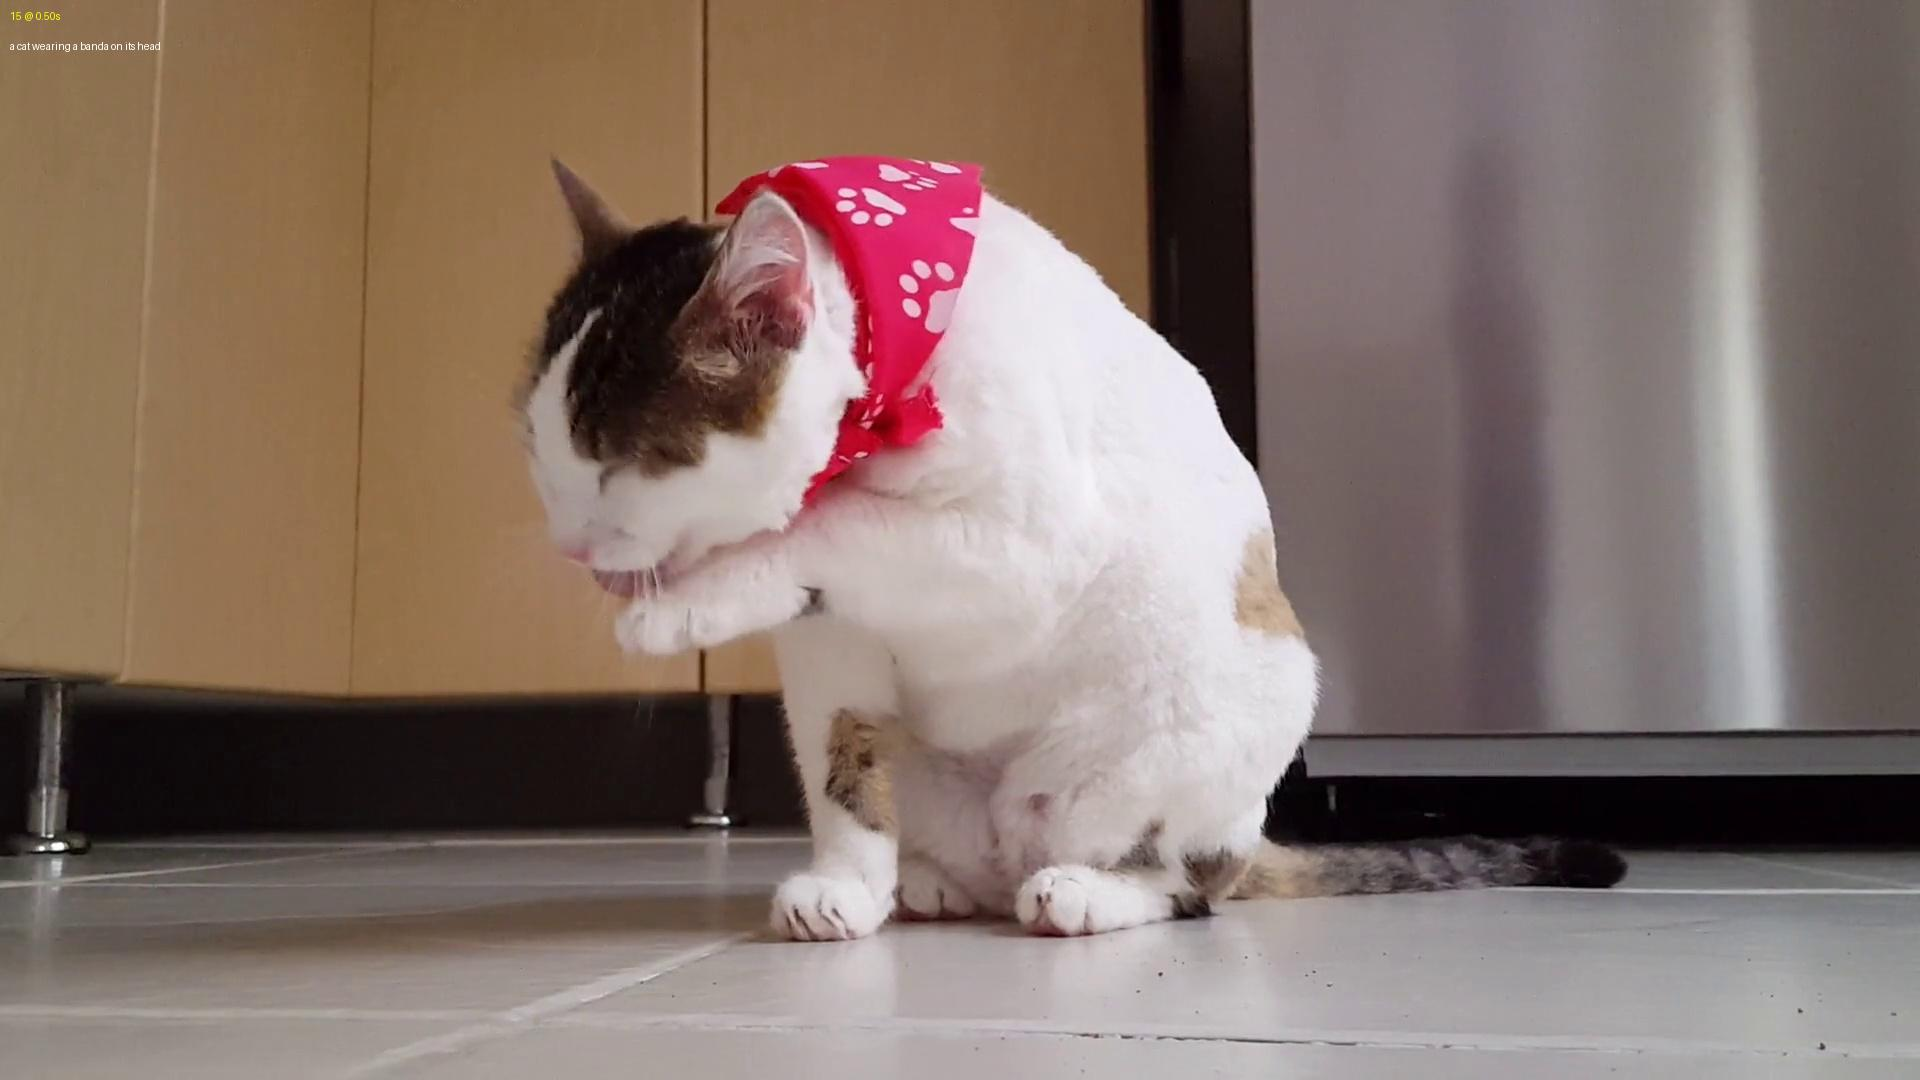

In [ ]:
from PIL import Image
import IPython.display as display

img = Image.open(os.path.join(out_frames_with_text, "frame_000015.jpg"))
display.display(img)


Saved video with captions: /content/out/video_with_captions.mp4


In [ ]:
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import os

out_frames_with_text = os.path.join(OUT_DIR, "frames_with_text")
os.makedirs(out_frames_with_text, exist_ok=True)

# اختيار خط واضح وكبير
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 48)
except:
    font = ImageFont.load_default()

for idx, row in enumerate(tqdm(rows, desc="Adding large centered captions")):
    img = Image.open(row["frame_path"]).convert("RGB")
    draw = ImageDraw.Draw(img)
    caption = row["caption"]

    W, H = img.size

    # نحسب مقاس النص باستخدام textbbox (بديل textsize)
    bbox = draw.textbbox((0, 0), caption, font=font)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]

    # نضع النص في منتصف الصورة من الأسفل
    x = (W - text_w) / 2
    y = H - text_h - 50  # 50 مسافة من تحت

    # خلفية سوداء نصف شفافة للنص
    margin = 15
    box = [(x - margin, y - margin), (x + text_w + margin, y + text_h + margin)]
    draw.rectangle(box, fill=(0, 0, 0, 180))

    # نرسم الكابشن باللون الأبيض
    draw.text((x, y), caption, font=font, fill=(255, 255, 255))

    outp = os.path.join(out_frames_with_text, f"frame_{idx:06d}.jpg")
    img.save(outp)

print("✅ Frames with large centered captions saved:", len(os.listdir(out_frames_with_text)))

Adding large centered captions: 100%|██████████| 47/47 [00:01<00:00, 36.00it/s]

✅ Frames with large centered captions saved: 90


In [ ]:
import ffmpeg
import os

# المسارات
captioned_frames = os.path.join(OUT_DIR, "frames_with_text")
output_video = os.path.join(OUT_DIR, "video_omar.mp4")

# 👇 استخدم معدل إطارات ثابت 5 فريم/ث (تقدر تزوده لو الفيديو قصير جداً)
FRAMERATE = 5

# 👇 لو عندك الفيديو الأصلي وعايز ترجّع الصوت كمان، حط مساره هنا
original_video = VIDEO_PATH  # لو مش عايز صوت سيب السطر زي ما هو

# --- تجميع الفريمات فقط (بدون صوت) ---
(
    ffmpeg
    .input(os.path.join(captioned_frames, "frame_%06d.jpg"), framerate=FRAMERATE)
    .output(output_video, vcodec='libx264', pix_fmt='yuv420p')
    .overwrite_output()
    .run(quiet=False)
)

print("🎞️ Video without sound saved:", output_video)

🎞️ Video without sound saved: /content/out/video_omar.mp4


In [ ]:
# --- 1️⃣ تثبيت مكتبة تحويل النص لصوت ---
!pip install gTTS pydub --quiet

from gtts import gTTS
from pydub import AudioSegment
from moviepy.editor import VideoFileClip, AudioFileClip, concatenate_audioclips
import os

# --- 2️⃣ توليد الصوت من الكابشنات ---
audio_clips = []
total_duration = 0
speech_dir = os.path.join(OUT_DIR, "speech")
os.makedirs(speech_dir, exist_ok=True)

# نرتب الكابشنات حسب timestamp
rows_sorted = sorted(rows, key=lambda x: x["timestamp_sec"])

for i, row in enumerate(rows_sorted):
    text = row["caption"].strip()
    if len(text) < 2:
        continue

    # إنشاء ملف صوتي مؤقت لكل كابشن
    tts = gTTS(text=text, lang="en")
    path_mp3 = os.path.join(speech_dir, f"caption_{i:03d}.mp3")
    tts.save(path_mp3)

    # تحميل الصوت وحسابه كـ AudioSegment
    clip = AudioSegment.from_file(path_mp3)
    audio_clips.append(clip)
    total_duration += clip.duration_seconds

# --- 3️⃣ دمج كل الأصوات مع بعض ---
if len(audio_clips) == 0:
    raise ValueError("❌ No captions with speech generated!")

combined_audio = sum(audio_clips)
final_audio_path = os.path.join(OUT_DIR, "captions_audio.mp3")
combined_audio.export(final_audio_path, format="mp3")

print(f"✅ Combined narration saved at: {final_audio_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if 

✅ Combined narration saved at: /content/out/captions_audio.mp3


In [ ]:
import ffmpeg
import os

video_with_text = os.path.join(OUT_DIR, "video_omar.mp4")
final_audio = os.path.join(OUT_DIR, "captions_audio.mp3")
final_output = os.path.join(OUT_DIR, "video_with_captions_and_voice.mp4")

# ✅ لازم نعرّف inputs منفصلة
video_input = ffmpeg.input(video_with_text)
audio_input = ffmpeg.input(final_audio)

(
    ffmpeg
    .output(video_input, audio_input, final_output, vcodec='copy', acodec='aac', shortest=None)
    .overwrite_output()
    .run()
)

print("🎤 Final video with spoken captions saved at:", final_output)


🎤 Final video with spoken captions saved at: /content/out/video_with_captions_and_voice.mp4
